# Plot temperature response over time

## Imports:

import numpy as np

In [1]:
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

### Paths input data

In [2]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

# PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


#### Uncertainty data from Chris

In [3]:
PATH_DT_UNCERTAINTY = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris.nc'

## Set values:

In [4]:
first_y = '1750'
last_y = '2100'

**Set reference year for temperature change:**

In [5]:
ref_year = '2020'

In [6]:
FIGURE_DIR = RESULTS_DIR / 'figures_recommendation/'

TABLE_DIR = RESULTS_DIR / 'tables_recommendation/'

In [7]:
from pathlib import Path
Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True)
Path(TABLE_DIR).mkdir(parents=True, exist_ok=True)

In [8]:
percentile = 'percentile'
climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [9]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    # 'aerosol-radiation_interactions',
    # 'aerosol-cloud_interactions',
    'aerosol-total',
    'o3',
    'HFCs',
    'bc_on_snow']
# total ERFs for anthropogenic and total:
#variables_erf_tot = ['total_anthropogenic',
#                     'total']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

### Scenarios:

In [10]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                #'ssp370-lowNTCF-gidden',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [11]:
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [12]:
ds_DT = xr.open_dataset(PATH_DT)
ds_uncertainty = xr.open_dataset(PATH_DT_UNCERTAINTY)

In [13]:
ds_DT.scenario  # .climatemodel

<xarray.DataArray 'scenario' (scenario: 10)>
array(['ssp534-over', 'ssp370-lowNTCF-gidden', 'ssp119', 'ssp370', 'ssp434',
       'ssp460', 'ssp585', 'ssp126', 'ssp245', 'ssp370-lowNTCF-aerchemmip'],
      dtype=object)
Coordinates:
  * scenario  (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-aerchemmip'

In [14]:
ds_DT.variable  # .climatemodel

<xarray.DataArray 'variable' (variable: 19)>
array(['co2', 'ch4', 'n2o', 'other_wmghg', 'o3', 'h2o_stratospheric',
       'contrails', 'aerosol-radiation_interactions',
       'aerosol-cloud_interactions', 'bc_on_snow', 'land_use', 'volcanic',
       'solar', 'total_anthropogenic', 'total_natural', 'total',
       'aerosol-total', 'aerosol-total-with_bc', 'HFCs'], dtype=object)
Coordinates:
  * variable  (variable) object 'co2' 'ch4' ... 'aerosol-total-with_bc' 'HFCs'

In [15]:
for var in variables_erf_comp:
    da5 = ds_uncertainty.sel(variable=var, scenario='ssp585')['p05-p50']    
    da95 = ds_uncertainty.sel(variable=var, scenario='ssp585')['p95-p50']
    da5.plot(label=var)
    da95.plot(label=var)
    

## Make csv table of total values:

In [16]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

<IPython.core.display.Javascript object>

In [17]:
name_deltaT = 'Delta T'

In [18]:
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y

_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: 
    _str += f'{var}, '

# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])


vn_sum = 'Sum SLCF (%s)' % _str[:-2]
print(vn_sum)
_st = vn_sum.replace('(','').replace(')','').replace(' ','_').replace(',','')+'.csv'


ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(year=int(s_y)).squeeze()
_da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(year=slice(int(s_y2), int(e_y2))) - ds_DT_sy
# Take recommendation::
_pl_da = _da.sel(percentile=recommendation)

df = _pl_da.to_pandas().transpose()
fn = TABLE_DIR/_st
df.to_csv(fn)

Sum SLCF (Methane, Aerosols, Ozone, HFCs, BC on snow)


## TABLE EACH VAR|

In [19]:
for var in variables_erf_comp:
    _str = ''
    _vl = var#[get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
    _st = f'{var}_deltaT_time.csv'


    ds_DT_sy = ds_DT[name_deltaT].sel(variable=var).sel(year=int(s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=var).sel(year=slice(int(s_y2), int(e_y2))) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)

    df = _pl_da.to_pandas().transpose()
    fn = TABLE_DIR/_st
    df.to_csv(fn)

### Define stuff:

## Plot $\Delta T$ from ref year:

In [20]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel
import numpy as np

In [21]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, \
    get_scenario_ls_dic


def get_fig_ax_tot(fgsize=None, nrows=2, ncols=3, rows_tot=0, cols_tot=2, tot_first=True, orientation='horizontal'):
    """
    Makes figure for total plot
    :param orientation: horizontal or vertical
    :param tot_first: plot with total comes first or second
    :param cols_tot:
    :param rows_tot:
    :param ncols:
    :param nrows:
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [11, 4.4]
    fg = plt.figure(constrained_layout=False, figsize=fgsize)
    if orientation == 'horizontal':
        _cols = ncols + cols_tot
        _rows = nrows
    else:
        _cols = ncols  # + cols_tot
        _rows = nrows + rows_tot

    spec2 = gridspec.GridSpec(ncols=_cols, nrows=_rows, figure=fg)
    com_axs = []
    if tot_first:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, 0:cols_tot])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, cols_tot + j]))
        else:

            all_ax = fg.add_subplot(spec2[0:rows_tot, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[rows_tot + i, j]))
    else:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, (-cols_tot):])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))
        else:

            all_ax = fg.add_subplot(spec2[(-rows_tot):, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))

    return fg, com_axs, all_ax


def get_fig_ax_tot_old(fgsize=None):
    """
    Makes figure for total plot
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [13, 12]
    _fig = plt.figure(constrained_layout=False, figsize=fgsize)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=_fig)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i == 1 and j == 2: continue
            com_axs.append(_fig.add_subplot(spec2[i, j * 4:(j + 1) * 4]))
    all_ax = _fig.add_subplot(spec2[2:, 2:10])
    return _fig, com_axs, all_ax


def fix_ax(_ax):
    # ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    # ax.set_xticks(list(ls))
    # ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    return


def fign_dt(_var, _s_y, _e_y):
    return '%s_refy%s_fy%s.png' % (_var.replace(' ', '_').replace('|', '-'), _s_y, _e_y)

In [22]:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: 
    _str += f'{var}, '

# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])


vn_sum = 'Sum SLCF (%s)' % _str[:-2]
print(vn_sum)
#_st = vn_sum.replace('(','').replace(')','').replace(' ','_').replace(',','')+'.csv'


_da_sum  = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable)
#_da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(year=slice(int(s_y2), int(e_y2))) - ds_DT_sy
_da_sum#.assin_coord()
#_ds_check = ds_DT.copy()
ds_DT
#xr.concat([_ds_check[name_deltaT],_da_sum], dim=variable)

dd1=_da_sum.expand_dims(
    {'variable':
    ['Sum SLCF (Methane, Aerosols, Ozone, HFCs, BC on snow)']})
#dd1=dd1.to_dataset()

ds_DT = xr.merge([ds_DT,dd1])

Sum SLCF (Methane, Aerosols, Ozone, HFCs, BC on snow)


In [23]:
def add_uncertainty_bar(ax, var, end_y = 2100, s_y = 2020,
                        to = 'p95-p50', 
                        frm='p05-p50',
                       linewidth=4,
                       i_plus = 1.5,
                        alpha = 1
                       ):
    _ds2100_err = ds_uncertainty.sel(year=end_y)
    _ds2100 = ds_DT.sel(year=end_y)-ds_DT.sel(year=s_y)
    #var = 'Sum SLCF (Methane, Aerosols, Ozone, HFCs, BC on snow)'
    #to = 'p95-p50'
    #frm = 'p05-p50'
    #_ds2100_err.sel(variable=var)
    i= end_y+1# 2101
    ax.set_xlim([2015,2100])
    #print(_ds2100.sel(scenario=scenarios_fl))
    for scn in scenarios_fl:
        _ds2100_err_scn = _ds2100_err.sel(scenario=scn, variable=var)
        _ds2100_scn = _ds2100.sel(scenario=scn, variable=var) 
        bot =float(-_ds2100_err_scn[frm])
        top = float(_ds2100_err_scn[to])

        mid = float(_ds2100_scn[name_deltaT])
        er = np.array([[bot,top],]).transpose()
        eb1 = ax.errorbar(i,mid, yerr=er ,c= cdic[scn], 
                      linestyle=lsdic[scn], linewidth=linewidth, 
                      alpha=alpha, zorder=100, clip_on=True,)
        #ax.scatter([i], [mid],c=cdic[scn],marker = '*',clip_on=False, zorder=100)
        i+=i_plus
        eb1[-1][0].set_linestyle(lsdic[scn])
        eb1[-1][0].set_clip_on(False)
    #linestyle=lsdic[scn], linewidth=linewidth
    #plt.tight_layout()
    #ax.set_xticks([2020,2040,2060,2080,2100])


ch4
aerosol-total
o3
HFCs
bc_on_snow


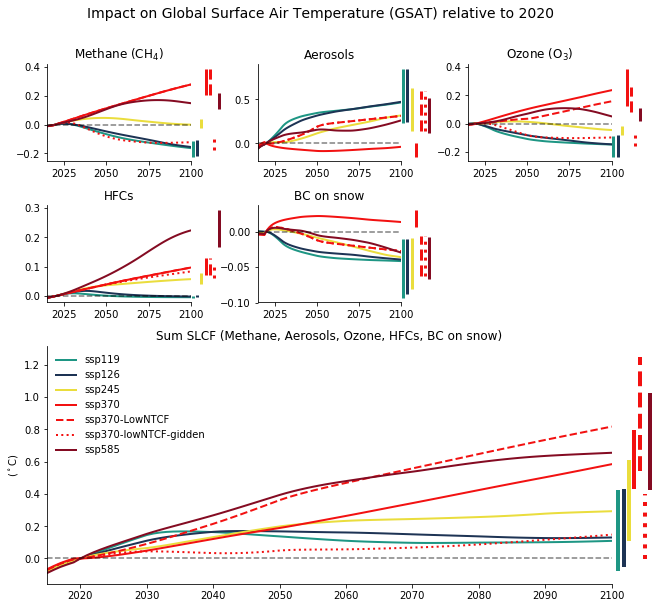

In [24]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

# get_fig_ax_tot

import matplotlib.pyplot as plt

figsize = [9, 8]#[6, 4]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

fig2, axs, ax_tot = get_fig_ax_tot(fgsize=figsize, rows_tot=2, cols_tot=0,
                                   orientation='vertical',
                                   tot_first=False)

# fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var, ax in zip(variables_erf_comp, axs):

    print(var)

    # fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in scenarios_fl:# list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile=recommendation)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))

    ax.set_ylabel('')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    add_uncertainty_bar(ax, var, linewidth=3, i_plus=2.6)
    
if len(axs)>len(variables_erf_comp):
    l = len(variables_erf_comp)
    for i in range(l,len(axs)):
        axs[l].axis('off')
# Total:

ax = ax_tot

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in scenarios_fl:#list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), linestyle=lsdic[scn], linewidth=linewidth)

    
var = 'Sum SLCF (Methane, Aerosols, Ozone, HFCs, BC on snow)'

add_uncertainty_bar(ax, var, linewidth=4, i_plus=.8)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Impact on Global Surface Air Temperature (GSAT) relative to 2020', fontsize=14, y=1.05)
# adjust plot visuals:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: _str += f'{var}, '
# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF (%s)' % _str[:-2])
# ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc='upper left')
fix_ax(ax)
plt.subplots_adjust(top=0.94, left=0.125, wspace=9.1, hspace=.5)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'total_ref2020_from2015_all_2.png', dpi=300)
plt.savefig(FIGURE_DIR / 'total_ref2020_from2015_all_2.pdf')  # , dpi=300)
plt.show()

In [25]:
import seaborn as sns

In [26]:
ax.get_ylim()

(-0.15669880000987035, 1.3149018963058734)

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.6, pack_start=False)
fig2.add_axes(cax, frameon=False)
sns.despine(ax = cax, left=True, right=True, bottom=True, top=True)

cax.set_ylim(ax.get_ylim())
cax.axis('off')

(0.0, 1.0, -0.15669880000987035, 1.3149018963058734)

ch4


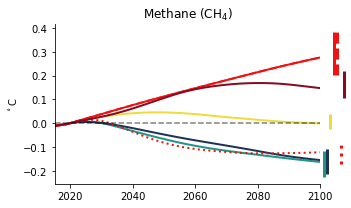

aerosol-total


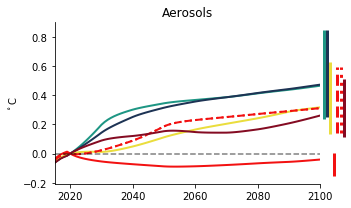

o3


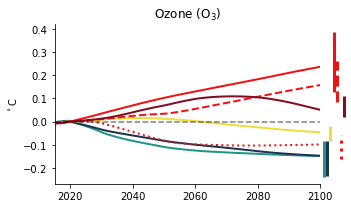

HFCs


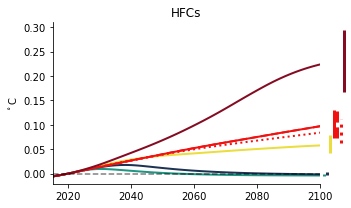

bc_on_snow


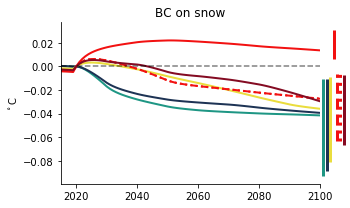

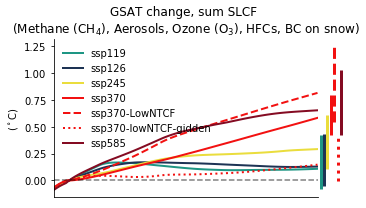

In [28]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel


# get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [5, 3]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

# fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var in variables_erf_comp:  # , axs):

    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in scenarios_fl:#list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile=recommendation)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))
    ax.set_ylabel('$^\circ$C')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    # figname
    fign = FIGURE_DIR / fign_dt(var, s_y, s_y2)
    make_folders(str(fign))
    #add_uncertainty_bar(ax, var, )
    add_uncertainty_bar(ax, var, linewidth=3, i_plus=1.1)


    plt.tight_layout()
    fig.subplots_adjust(right=.9) # or whatever

    plt.savefig(fign, dpi=300)
    plt.savefig(fign.with_suffix('.pdf'))  
    plt.show()

axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    # ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')

fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in scenarios_fl:#list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle=lsdic[scn],
                linewidth=linewidth)
var = 'Sum SLCF (Methane, Aerosols, Ozone, HFCs, BC on snow)'

add_uncertainty_bar(ax, var, linewidth=3, i_plus=1.1)

# adjust plot visuals:
_str = ''
for var in ds_DT.sel(variable=variables_erf_comp)[variable].values: _str += f'{get_var_nicename(var)}, '
ax.set_title('GSAT change, sum SLCF \n(%s)' % _str[:-2])

ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')

plt.tight_layout()
fn = FIGURE_DIR / fign_dt('total', s_y, s_y2)
plt.savefig(fn, dpi=200)
plt.savefig(fn.with_suffix('.pdf'))  # , dpi=200)
plt.show()

# Supplementary plots:

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

In [29]:
scenarios_fl=['ssp119',
 'ssp126',
 'ssp245',
# 'ssp370',
 'ssp370-lowNTCF-aerchemmip',
 'ssp370-lowNTCF-gidden',
 'ssp585']

In [30]:
ref_year

'2020'

ch4


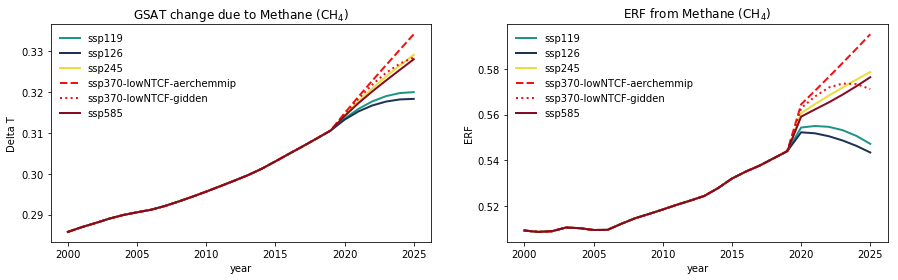

aerosol-total


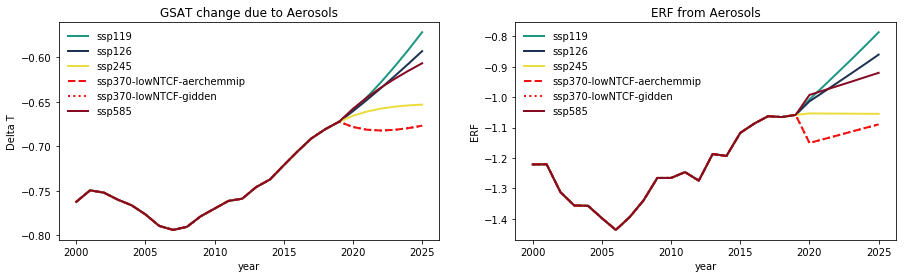

o3


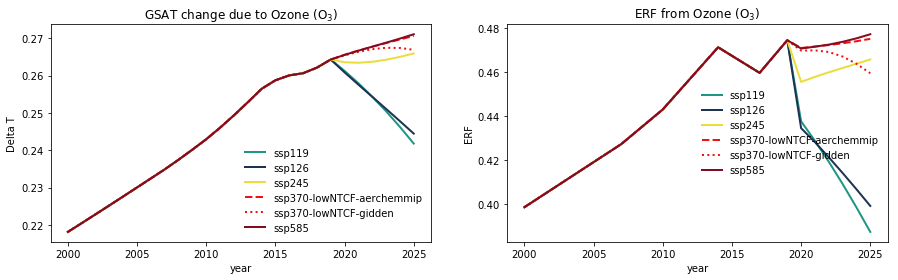

HFCs


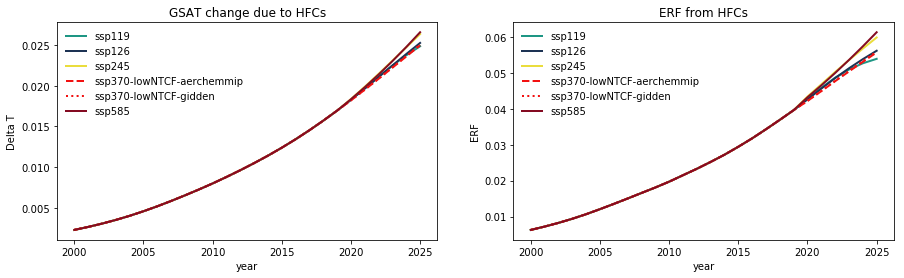

bc_on_snow


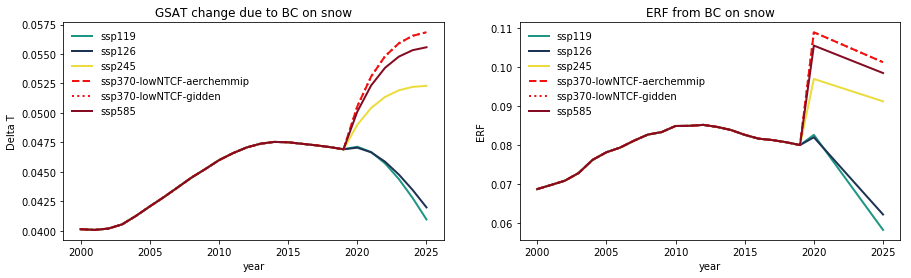

In [31]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True

        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(2000,2025)).sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(2000,2025))
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()

Subtracting year 2020, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2020

ch4


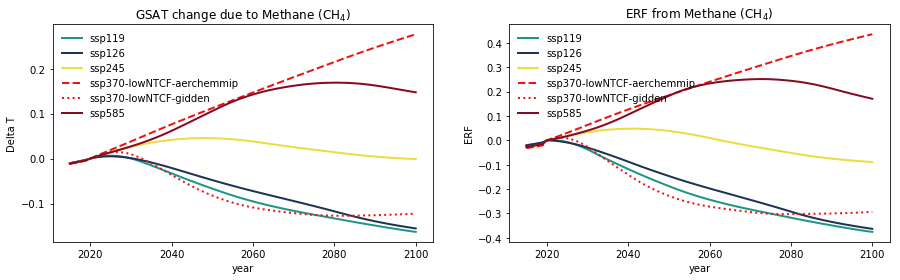

aerosol-total


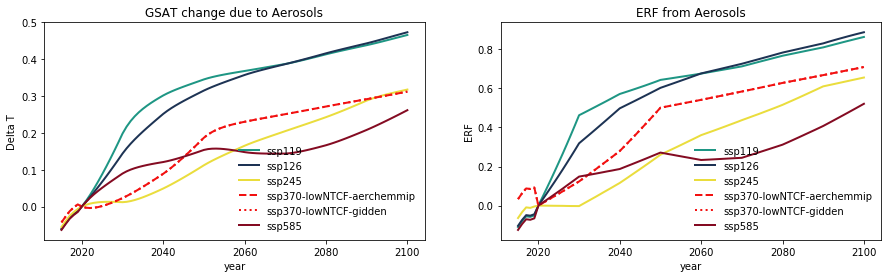

o3


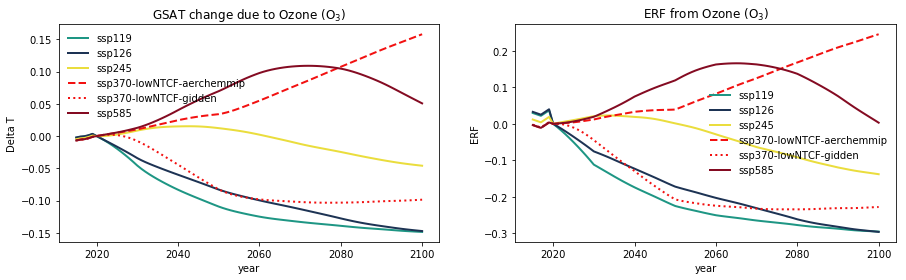

HFCs


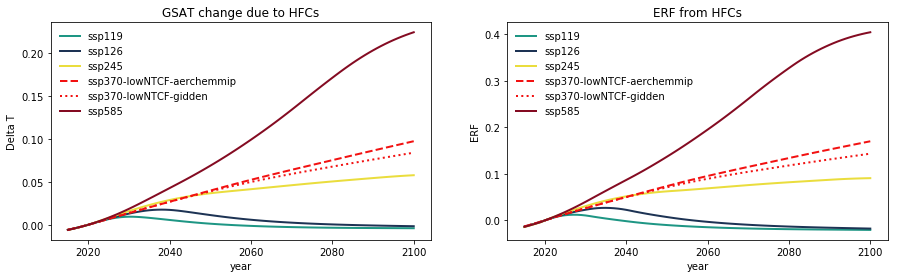

bc_on_snow


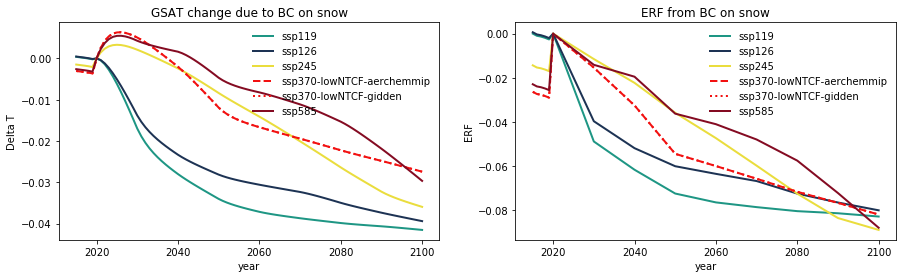

In [34]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True
        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT[name_deltaT].sel(
            variable=var, scenario=scn,
            year=slice(s_y, s_y)).squeeze()
        _da1 = _da1.sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT['ERF'].sel(variable=var,
                                                                                                       scenario=scn,
                                                                                                       year=slice(s_y,
                                                                                                                  s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()